In [1]:
BASE_DIR = r"D:\Projects\CLARITY\Model\Dataset\archive"   # root containing image_*/images/*.png
CSV_PATH = r"D:\Projects\CLARITY\Model\Dataset\archive\Data_Entry_2017.csv"
OUTPUT_DIR = r"./outputs_resnet"
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [2]:
import os, time, json, random, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

# PyTorch & torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
from torchvision import models

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (f1_score, precision_score, recall_score, roc_auc_score,
                             roc_curve, auc, classification_report, multilabel_confusion_matrix,
                             precision_recall_curve)


from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from ipywidgets import VBox, HBox, Label, FloatProgress, HTML
from IPython.display import display, clear_output

In [3]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [4]:
class FocalLoss(nn.Module):
    """Multi-label focal loss (binary focal on each label)."""
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', logits=True):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.logits = logits
    def forward(self, inputs, targets):
        if self.logits:
            bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            bce = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-bce)
        loss = self.alpha * (1-pt)**self.gamma * bce
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

def save_history(history, path):
    with open(path, 'w') as f:
        json.dump(history, f, indent=2)

Total CSV rows: 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


Detected classes: 15
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


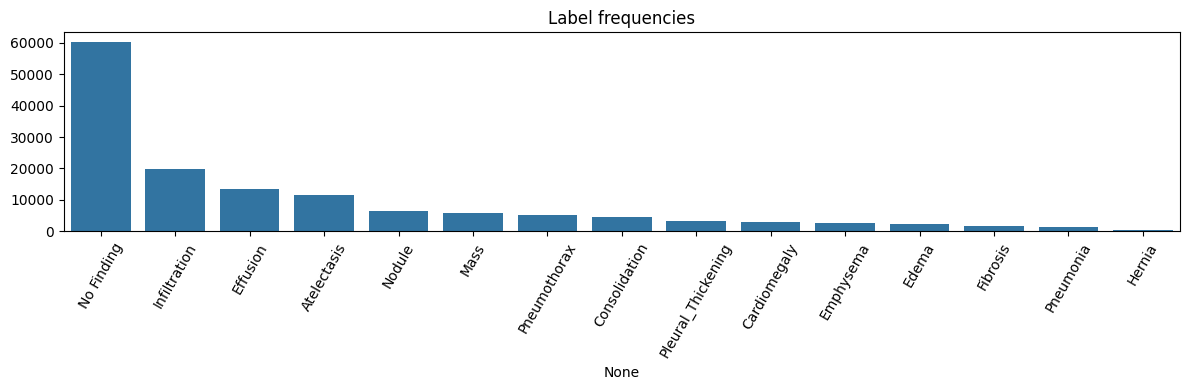

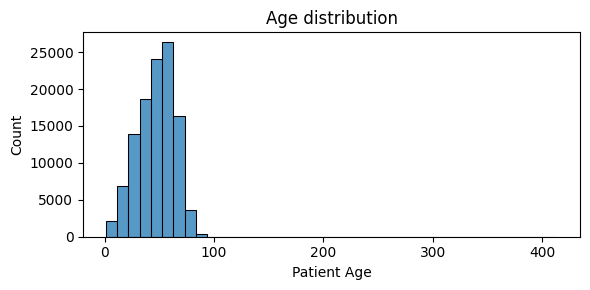

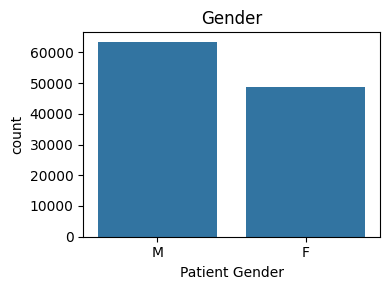

In [5]:
df = pd.read_csv(CSV_PATH)
# normalize labels formatting (remove leading/trailing spaces around '|')
df['Finding Labels'] = df['Finding Labels'].astype(str).apply(lambda x: '|'.join([s.strip() for s in x.split('|')]))
print("Total CSV rows:", len(df))
display(df.head())

# build class list
all_labels = sorted({lab for row in df['Finding Labels'].astype(str) for lab in row.split('|')})
print("Detected classes:", len(all_labels))
print(all_labels)

# quick label frequency plot (multi-label)
mlb_temp = MultiLabelBinarizer(classes=all_labels)
y_all = mlb_temp.fit_transform(df['Finding Labels'].str.split('|'))
label_counts = pd.Series(y_all.sum(axis=0), index=mlb_temp.classes_).sort_values(ascending=False)
plt.figure(figsize=(12,4)); sns.barplot(x=label_counts.index, y=label_counts.values); plt.xticks(rotation=60); plt.title("Label frequencies"); plt.tight_layout(); plt.savefig(Path(OUTPUT_DIR)/"label_freq.png", dpi=150); plt.show()

# Age/gender if available
if 'Patient Age' in df.columns:
    plt.figure(figsize=(6,3)); sns.histplot(df['Patient Age'].dropna().astype(float), bins=40); plt.title('Age distribution'); plt.tight_layout(); plt.savefig(Path(OUTPUT_DIR)/"age_dist.png", dpi=150); plt.show()
if 'Patient Gender' in df.columns:
    plt.figure(figsize=(4,3)); sns.countplot(x='Patient Gender', data=df); plt.title('Gender'); plt.tight_layout(); plt.savefig(Path(OUTPUT_DIR)/"gender_count.png", dpi=150); plt.show()

In [6]:
print("Caching image paths...")
img_map = {}
root = Path(BASE_DIR)
for sub in root.iterdir():
    if not sub.is_dir(): continue
    images_dir = sub / "images"
    if not images_dir.exists(): continue
    for p in images_dir.iterdir():
        if p.suffix.lower() in ('.png', '.jpg', '.jpeg'):
            img_map[p.name] = str(p)
print("Cached images:", len(img_map))

# keep only entries that exist
df['exists'] = df['Image Index'].apply(lambda x: x in img_map)
missing = (~df['exists']).sum()
print("Missing entries (not found on disk):", missing)
df = df[df['exists']].reset_index(drop=True)
print("After filtering:", len(df))

Caching image paths...
Cached images: 112120
Missing entries (not found on disk): 0
After filtering: 112120


In [7]:
mlb = MultiLabelBinarizer(classes=all_labels)
labels_bin = mlb.fit_transform(df['Finding Labels'].str.split('|'))
for i, c in enumerate(mlb.classes_):
    df[c] = labels_bin[:, i]
print("Added binary label columns.")

Added binary label columns.


In [8]:
if 'Patient ID' in df.columns:
    patients = df['Patient ID'].unique()
    # 80/10/10 split of patients
    train_pats, tmp_pats = train_test_split(patients, test_size=0.2, random_state=SEED)
    val_pats, test_pats = train_test_split(tmp_pats, test_size=0.5, random_state=SEED)
    train_df = df[df['Patient ID'].isin(train_pats)].reset_index(drop=True)
    val_df   = df[df['Patient ID'].isin(val_pats)].reset_index(drop=True)
    test_df  = df[df['Patient ID'].isin(test_pats)].reset_index(drop=True)
else:
    # fallback: stratify by most frequent single label (not perfect but better than plain)
    df['primary_label'] = df[mlb.classes_].idxmax(axis=1)
    train_df, tmp_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['primary_label'])
    val_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=SEED, stratify=tmp_df['primary_label'])
    train_df = train_df.reset_index(drop=True); val_df = val_df.reset_index(drop=True); test_df = test_df.reset_index(drop=True)
    df.drop(columns=['primary_label'], inplace=True)

print("Split sizes -> Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

Split sizes -> Train: 89826 Val: 10930 Test: 11364


In [9]:
IMG_SIZE = 224
BATCH_SIZE = 16        # adjust depending on GPU memory
NUM_WORKERS = 0        # set >0 on Linux for speed; 0 is safe on Windows/Mac
PIN_MEMORY = True if DEVICE.type == 'cuda' else False

train_transforms = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(brightness=0.12, contrast=0.12, saturation=0.05)], p=0.5),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
val_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

class CLARITYDataset(Dataset):
    def __init__(self, df, img_map, classes, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_map = img_map
        self.transform = transform
        self.classes = classes
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['Image Index']
        path = self.img_map.get(img_name)
        if path is None:
            # return a black image in case of missing - robust handling
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), (0,0,0))
        else:
            img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        labels = torch.tensor(row[self.classes].values.astype(np.float32))
        return img, labels

train_dataset = CLARITYDataset(train_df, img_map, mlb.classes_, transform=train_transforms)
val_dataset = CLARITYDataset(val_df, img_map, mlb.classes_, transform=val_transforms)
test_dataset = CLARITYDataset(test_df, img_map, mlb.classes_, transform=val_transforms)

In [10]:
train_labels = train_df[mlb.classes_].values
class_counts_train = train_labels.sum(axis=0)
# avoid zero division
inv_class_freq = 1.0 / (class_counts_train + 1e-6)
sample_weights = []
for row in train_labels:
    if row.sum() == 0:
        sample_weights.append(1.0)
    else:
        sample_weights.append(float((inv_class_freq * row).sum()))
sample_weights = np.array(sample_weights)
sample_weights = sample_weights / np.mean(sample_weights)

train_sampler = WeightedRandomSampler(sample_weights.tolist(), num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# quick check
imgs, labs = next(iter(train_loader))
print("Sample batch:", imgs.shape, labs.shape)

Sample batch: torch.Size([16, 3, 224, 224]) torch.Size([16, 15])


In [11]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
# replace final fc
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features, len(mlb.classes_))
)
model = model.to(DEVICE)

# optionally freeze backbone for first few epochs (helpful)
def set_requires_grad(model, requires_grad=False):
    for name, param in model.named_parameters():
        # keep final fc trainable
        if 'fc' in name:
            param.requires_grad = True
        else:
            param.requires_grad = requires_grad

In [13]:
use_focal = True  # set True to use FocalLoss instead of BCEWithLogits
# pos_weight for BCEWithLogitsLoss: ratio max_count / count
pos_weight = torch.tensor((class_counts_train.max() / (class_counts_train + 1e-6))).float().to(DEVICE)

if use_focal:
    criterion = FocalLoss(alpha=1.0, gamma=2.0, logits=True)
else:
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# optimizer: smaller LR for finetuning
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
# scheduler: ReduceLROnPlateau (no verbose arg)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# callbacks
checkpoint_path = Path(OUTPUT_DIR)/"best_model_resnet.pth"

In [ ]:
EPOCHS = 20  # shorter first; increase after tuning
scaler = torch.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))

history = {'train_loss':[], 'val_loss':[], 'val_auc':[], 'val_f1':[]}

lp = FloatProgress(min=0, max=EPOCHS)
train_loss_label = Label("train_loss: -")
val_loss_label = Label("val_loss: -")
val_f1_label = Label("val_f1: -")
val_auc_label = Label("val_auc: -")
display(VBox([lp, HBox([train_loss_label, val_loss_label, val_f1_label, val_auc_label])]))

# Optionally freeze backbone for first 2 epochs -> train only fc
set_requires_grad(model, requires_grad=False)
for name, p in model.named_parameters():
    if p.requires_grad:
        print("Trainable:", name)

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    # unfreeze after 2 epochs
    if epoch == 3:
        set_requires_grad(model, requires_grad=True)
        print("Unfreezed backbone for fine-tuning.")

    # training
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]")
    for imgs, labels in pbar:
        imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
        optimizer.zero_grad()
        # AMP context
        with torch.amp.autocast(device_type=DEVICE.type):
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        # backprop
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * imgs.size(0)
        pbar.set_postfix(loss=loss.item())
    epoch_train_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(epoch_train_loss)

    # validation
    model.eval()
    val_loss = 0.0
    all_probs, all_targets = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
            with torch.amp.autocast(device_type=DEVICE.type):
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            all_probs.append(torch.sigmoid(outputs).cpu().numpy())
            all_targets.append(labels.cpu().numpy())
    epoch_val_loss = val_loss / len(val_loader.dataset)
    history['val_loss'].append(epoch_val_loss)
    all_probs = np.vstack(all_probs); all_targets = np.vstack(all_targets)

    # metrics
    try:
        val_auc = roc_auc_score(all_targets, all_probs, average='macro')
    except Exception:
        val_auc = float('nan')
    y_pred_bin = (all_probs > 0.5).astype(int)
    val_f1 = f1_score(all_targets, y_pred_bin, average='macro', zero_division=0)

    history['val_auc'].append(float(val_auc)); history['val_f1'].append(float(val_f1))

    # scheduler step
    scheduler.step(epoch_val_loss)

    t1 = time.time()
    print(f"Epoch {epoch}: Train Loss={epoch_train_loss:.4f}, Val Loss={epoch_val_loss:.4f}, Val F1={val_f1:.4f}, Val AUC={val_auc:.4f}, Time={(t1-t0)/60:.2f} min")

    lp.value = epoch
    train_loss_label.value = f"train_loss: {epoch_train_loss:.4f}"
    val_loss_label.value   = f"val_loss: {epoch_val_loss:.4f}"
    val_f1_label.value     = f"val_f1: {val_f1:.4f}"
    val_auc_label.value    = f"val_auc: {val_auc:.4f}"

# save history & plots
save_history(history, Path(OUTPUT_DIR)/"training_history_resnet.json")
plt.figure(figsize=(10,4)); 
plt.plot(history['train_loss'], label='train_loss'); 
plt.plot(history['val_loss'], label='val_loss'); 
plt.xlabel('epoch'); 
plt.ylabel('loss'); plt.legend(); 
plt.title('Loss curves'); 
plt.savefig(Path(OUTPUT_DIR)/"loss_curves_resnet.png", dpi=150); 
plt.show()

Trainable: fc.1.weight
Trainable: fc.1.bias


Epoch 1/20 [Train]: 100%|██████████████████████████████████████████████| 5615/5615 [28:10<00:00,  3.32it/s, loss=0.108]


Epoch 1: Train Loss=0.0966, Val Loss=0.0781, Val F1=0.0143, Val AUC=0.6829, Time=31.32 min


Epoch 2/20 [Train]: 100%|██████████████████████████████████████████████| 5615/5615 [28:15<00:00,  3.31it/s, loss=0.108]


Epoch 2: Train Loss=0.0935, Val Loss=0.0766, Val F1=0.0227, Val AUC=0.6963, Time=31.42 min
Unfreezed backbone for fine-tuning.


Epoch 3/20 [Train]: 100%|█████████████████████████████████████████████| 5615/5615 [31:42<00:00,  2.95it/s, loss=0.0832]


Epoch 3: Train Loss=0.0795, Val Loss=0.0684, Val F1=0.2223, Val AUC=0.7987, Time=34.86 min


Epoch 4/20 [Train]: 100%|█████████████████████████████████████████████| 5615/5615 [31:41<00:00,  2.95it/s, loss=0.0967]


Epoch 4: Train Loss=0.0690, Val Loss=0.0702, Val F1=0.2456, Val AUC=0.7907, Time=34.83 min


Epoch 5/20 [Train]: 100%|█████████████████████████████████████████████| 5615/5615 [31:37<00:00,  2.96it/s, loss=0.0293]


Epoch 5: Train Loss=0.0623, Val Loss=0.0661, Val F1=0.2458, Val AUC=0.7770, Time=34.79 min


Epoch 6/20 [Train]: 100%|█████████████████████████████████████████████| 5615/5615 [31:38<00:00,  2.96it/s, loss=0.0424]


Epoch 6: Train Loss=0.0561, Val Loss=0.0686, Val F1=0.2541, Val AUC=0.7623, Time=34.80 min


Epoch 7/20 [Train]: 100%|██████████████████████████████████████████████| 5615/5615 [31:40<00:00,  2.95it/s, loss=0.117]


Epoch 7: Train Loss=0.0504, Val Loss=0.0720, Val F1=0.2462, Val AUC=0.7597, Time=34.81 min


Epoch 8/20 [Train]: 100%|█████████████████████████████████████████████| 5615/5615 [31:39<00:00,  2.96it/s, loss=0.0506]


Epoch 8: Train Loss=0.0455, Val Loss=0.0745, Val F1=0.2412, Val AUC=0.7554, Time=34.81 min


Epoch 9/20 [Train]: 100%|█████████████████████████████████████████████| 5615/5615 [31:37<00:00,  2.96it/s, loss=0.0825]


Epoch 9: Train Loss=0.0372, Val Loss=0.0816, Val F1=0.2435, Val AUC=0.7480, Time=34.79 min


Epoch 10/20 [Train]: 100%|████████████████████████████████████████████| 5615/5615 [31:36<00:00,  2.96it/s, loss=0.0554]


Epoch 10: Train Loss=0.0328, Val Loss=0.0807, Val F1=0.2599, Val AUC=0.7476, Time=34.76 min


Epoch 11/20 [Train]: 100%|████████████████████████████████████████████| 5615/5615 [31:38<00:00,  2.96it/s, loss=0.0654]


Epoch 11: Train Loss=0.0299, Val Loss=0.0826, Val F1=0.2571, Val AUC=0.7350, Time=34.78 min


Epoch 12/20 [Train]: 100%|████████████████████████████████████████████| 5615/5615 [31:36<00:00,  2.96it/s, loss=0.0504]


Epoch 12: Train Loss=0.0259, Val Loss=0.0848, Val F1=0.2526, Val AUC=0.7370, Time=34.77 min


Epoch 13/20 [Train]:   2%|▉                                            | 111/5615 [00:38<31:03,  2.95it/s, loss=0.0216]

In [ ]:
if Path(checkpoint_path).exists():
    ckpt = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(ckpt['model_state'])
    print("Loaded best checkpoint.")
else:
    print("No checkpoint found; using current model weights.")

model.eval()
all_probs, all_targets = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Predicting test set"):
        imgs = imgs.to(DEVICE)
        with torch.amp.autocast(device_type=DEVICE.type):
            outputs = model(imgs)
        all_probs.append(torch.sigmoid(outputs).cpu().numpy())
        all_targets.append(labels.numpy())
all_probs = np.vstack(all_probs); all_targets = np.vstack(all_targets)
# try compute optimal threshold per class using val set (recompute val probs)
val_probs, val_targs = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        with torch.amp.autocast(device_type=DEVICE.type):
            outputs = model(imgs)
        val_probs.append(torch.sigmoid(outputs).cpu().numpy()); val_targs.append(labels.numpy())
val_probs = np.vstack(val_probs); val_targs = np.vstack(val_targs)

optimal_thresholds = []
for i in range(len(mlb.classes_)):
    try:
        prec, rec, thr = precision_recall_curve(val_targs[:,i], val_probs[:,i])
        f1s = 2*prec*rec/(prec+rec+1e-12)
        if len(f1s) == 0:
            best_t = 0.5
        else:
            best_idx = np.nanargmax(f1s[:-1]) if len(thr)>0 else -1
            best_t = thr[best_idx] if best_idx >= 0 else 0.5
    except Exception:
        best_t = 0.5
    optimal_thresholds.append(float(best_t))
print("First 10 optimal thresholds:", optimal_thresholds[:10])

y_pred = (all_probs >= np.array(optimal_thresholds)[None,:]).astype(int)

# global metrics
f1_macro = f1_score(all_targets, y_pred, average='macro', zero_division=0)
precision_macro = precision_score(all_targets, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(all_targets, y_pred, average='macro', zero_division=0)
try:
    auc_macro = roc_auc_score(all_targets, all_probs, average='macro')
except:
    auc_macro = float('nan')
print(f"Test: F1_macro={f1_macro:.4f}, Precision={precision_macro:.4f}, Recall={recall_macro:.4f}, AUC={auc_macro:.4f}")

# save classification report & preds
report = classification_report(all_targets, y_pred, target_names=mlb.classes_, zero_division=0)
with open(Path(OUTPUT_DIR)/"classification_report_resnet.txt", "w") as f:
    f.write(report)
print(report)

pd.DataFrame(all_probs, columns=mlb.classes_).to_csv(Path(OUTPUT_DIR)/"test_probs_resnet.csv", index=False)
pd.DataFrame(y_pred, columns=mlb.classes_).to_csv(Path(OUTPUT_DIR)/"test_preds_resnet.csv", index=False)
pd.DataFrame(optimal_thresholds, index=mlb.classes_, columns=['threshold']).to_csv(Path(OUTPUT_DIR)/"optimal_thresholds_resnet.csv")

# per-class f1 barplot
per_f1 = []
for i,c in enumerate(mlb.classes_):
    per_f1.append(f1_score(all_targets[:,i], y_pred[:,i], zero_division=0))
plt.figure(figsize=(12,4)); sns.barplot(x=mlb.classes_, y=per_f1); plt.xticks(rotation=60); plt.ylabel("F1"); plt.title("Per-class F1"); plt.tight_layout(); plt.savefig(Path(OUTPUT_DIR)/"per_class_f1_resnet.png", dpi=150); plt.show()

# multilabel confusion matrix for first 6 classes
mcm = multilabel_confusion_matrix(all_targets, y_pred)
for i, label in enumerate(mlb.classes_[:6]):
    plt.figure(figsize=(3,3)); sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues'); plt.title(f"Confusion Matrix: {label}"); plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout(); plt.savefig(Path(OUTPUT_DIR)/f"cm_{label}_resnet.png", dpi=150); plt.show()

# ROC for top 6 classes
plt.figure(figsize=(8,6))
for i,label in enumerate(mlb.classes_[:6]):
    try:
        fpr,tpr,_ = roc_curve(all_targets[:,i], all_probs[:,i])
        roc_auc = auc(fpr,tpr)
        plt.plot(fpr,tpr,label=f"{label} (AUC={roc_auc:.2f})")
    except:
        pass
plt.plot([0,1],[0,1],'k--'); plt.legend(loc='lower right'); plt.title("ROC for top classes"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.savefig(Path(OUTPUT_DIR)/"roc_top6_resnet.png", dpi=150); plt.show()

In [ ]:
try:
    # target layer for ResNet50
    target_layer = model.layer4[-1].conv3
    cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=(DEVICE.type=='cuda'))
    sel_idx = np.random.choice(len(test_dataset), size=min(6, len(test_dataset)), replace=False)
    os.makedirs(Path(OUTPUT_DIR)/"gradcam_resnet", exist_ok=True)
    for k, idx in enumerate(sel_idx):
        img_tensor, label = test_dataset[idx]
        input_tensor = img_tensor.unsqueeze(0).to(DEVICE)
        grayscale_cam = cam(input_tensor=input_tensor)[0]
        img_np = img_tensor.permute(1,2,0).numpy()
        img_for_vis = (img_np - img_np.min())/(img_np.max() - img_np.min() + 1e-8)
        visualization = show_cam_on_image(img_for_vis, grayscale_cam, use_rgb=True)
        plt.figure(figsize=(5,5)); plt.imshow(visualization); plt.axis('off')
        gt_labels = [mlb.classes_[i] for i in range(len(label)) if label[i]==1]
        plt.title(f"GT: {gt_labels}"); outpath = Path(OUTPUT_DIR)/f"gradcam_resnet_{k}.png"; plt.savefig(outpath, bbox_inches='tight', dpi=150); plt.show()
except Exception as e:
    print("Grad-CAM failed:", e)

In [ ]:
torch.save({'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict()}, Path(OUTPUT_DIR)/"final_model_resnet.pth")
save_history(history, Path(OUTPUT_DIR)/"history_resnet.json")
print("All outputs saved to", OUTPUT_DIR)